In [2]:
library(dplyr)
library(tidyverse)
library(magrittr)
library(MASS)
library(class)
library(caret)
library(VGAM)
library(randomForest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: stats

In [155]:
# transformed data import for multi & rf
star <- read.csv("./Rdata/PhaseA_star.csv")

In [156]:
# transfer variable types for alogrithms 
star <- star %>% mutate(
  class = factor(class),
  cam_col = factor(cam_col),
  fieldbin = factor(fieldbin),
  runbin = factor(runbin)  
)

### 1.Train, Holdout Split on full dataset. 

In [157]:
# train holdo split
set.seed(447)
train<- sample_n(star, size = nrow(star) * 0.80,
  replace = FALSE
)

holdo <- anti_join(star,
  train,
  by = "X"
)

In [158]:
# drop X(id) col in holdo
holdo <- holdo[-1]

### 2. Loading functions which will be used during computation

In [161]:
# category PI function from course
CategoryPredInterval = function(ProbMatrix,labels)
{ ncases=nrow(ProbMatrix)
    pred50=rep(NA,ncases);   pred80=rep(NA,ncases);
     data.frame(pred50); data.frame(pred80);
    for(i in 1:ncases)
    {    
        p=ProbMatrix[i,]
        ip=order(p,decreasing=T)
        pOrdered=p[ip] # decreasing order
        labelsOrdered=labels[ip] # decreasing order
        G=cumsum(pOrdered) # cumulative sum from largest
        k1=min(which(G>=0.5)) # level1= 0.5
        k2=min(which(G>=0.8)) # level2= 0.8
        pred1=labelsOrdered[1:k1]; 
        pred2=labelsOrdered[1:k2]
        pred50[i]=paste(pred1,collapse="")
        pred80[i]=paste(pred2,collapse="")
    }
    data.frame(pred50=pred50, pred80=pred80)
}

In [162]:
categMisclassRates = function(predIntervalMatrix, iprint=FALSE)
{ cols = colnames(predIntervalMatrix)
rows = rownames(predIntervalMatrix)
misclass = rep(0,length(rows))
for (i in 1:length(rows))
{ row = predIntervalMatrix[i,]
total = sum(row)
class = rows[i]
count = 0
for (j in 1:length(cols))
    { col = cols[j]
if (grepl(class, col, fixed = TRUE)) { count = count + row[col] }
}
misclass[i] = 1 - count/total
if(iprint) cat("Number of misclassifications for ", class, ":", total - count, "\n")
cat("Misclassification rate for ", class, ": ", round(misclass[i], 3), "\n")
}
cat("Avg Misclassification rate: ", round(mean(misclass[]), 3), "\n")
return(misclass)}

#### 2.1 Cross Validation Fold Split

In [15]:
set.seed(447)

# 3-fold, preparation for cross-validated performance
n = nrow(train)
iperm=sample(n)
nFold <- round(n/3) 
ifold1=iperm[1:nFold]
ifold2=iperm[(nFold+1):(2*nFold)]
ifold3=iperm[(2*nFold+1):(n)]

#cv1: ifold1&2 
trainDat1<-train[-ifold3,-which(colnames(train) == "X")]
testDat1<-train[ifold3, -which(colnames(train) == "X")]

#fold2: ifold2&3
trainDat2<-train[-ifold1,-which(colnames(train) == "X")]
testDat2<-train[ifold1,-which(colnames(train) == "X")]

#fold3: ifold1&3 
trainDat3<-train[-ifold2,-which(colnames(train) == "X")]
testDat3<-train[ifold2,-which(colnames(train) == "X")]

### 3. Method Implementation

### 3.1 Method 1 - RF

#### 3.1.1 RF CV


Call:
 randomForest(formula = class ~ ., data = trainDat1[-1], ntree = ntrees) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.68%
Confusion matrix:
       GALAXY  QSO  STAR  class.error
GALAXY  31088  396   188 0.0184389997
QSO       837 9348     3 0.0824499411
STAR        6    0 11466 0.0005230126


,GALAXY,QSO,STAR
27615,0.1200,0.005,0.8750
53768,0.9750,0.025,0.0000
32807,0.9950,0.005,0.0000
49484,0.0675,0.930,0.0025
35770,0.9675,0.030,0.0025
9008,1.0000,0.000,0.0000



Call:
 randomForest(formula = class ~ ., data = trainDat2[-1], ntree = ntrees) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.67%
Confusion matrix:
       GALAXY  QSO  STAR class.error
GALAXY  31241  392   182 0.018041804
QSO       834 9311     1 0.082298443
STAR       13    0 11359 0.001143159


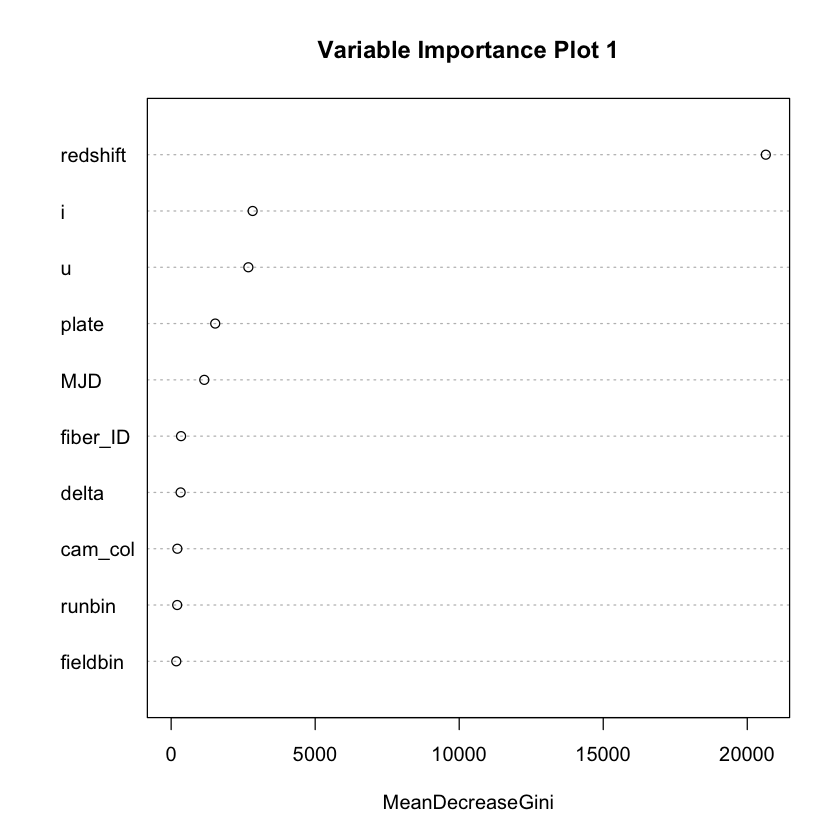


Call:
 randomForest(formula = class ~ ., data = trainDat3[-1], ntree = ntrees) 
               Type of random forest: classification
                     Number of trees: 400
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.71%
Confusion matrix:
       GALAXY  QSO  STAR  class.error
GALAXY  31145  389   179 0.0179106360
QSO       861 9274     3 0.0852239100
STAR       11    0 11471 0.0009580213


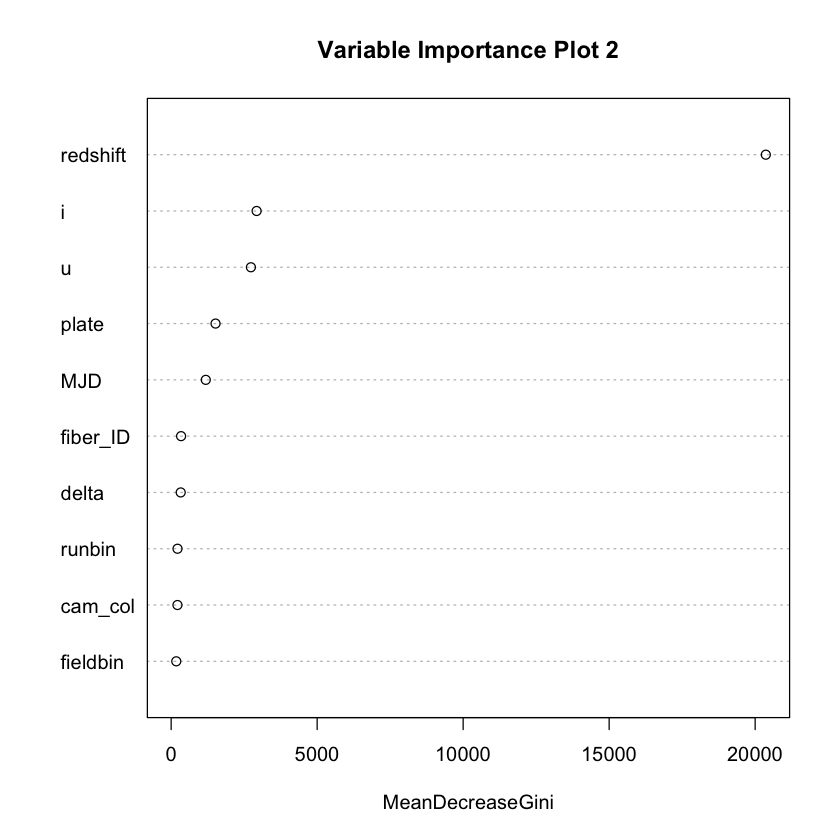

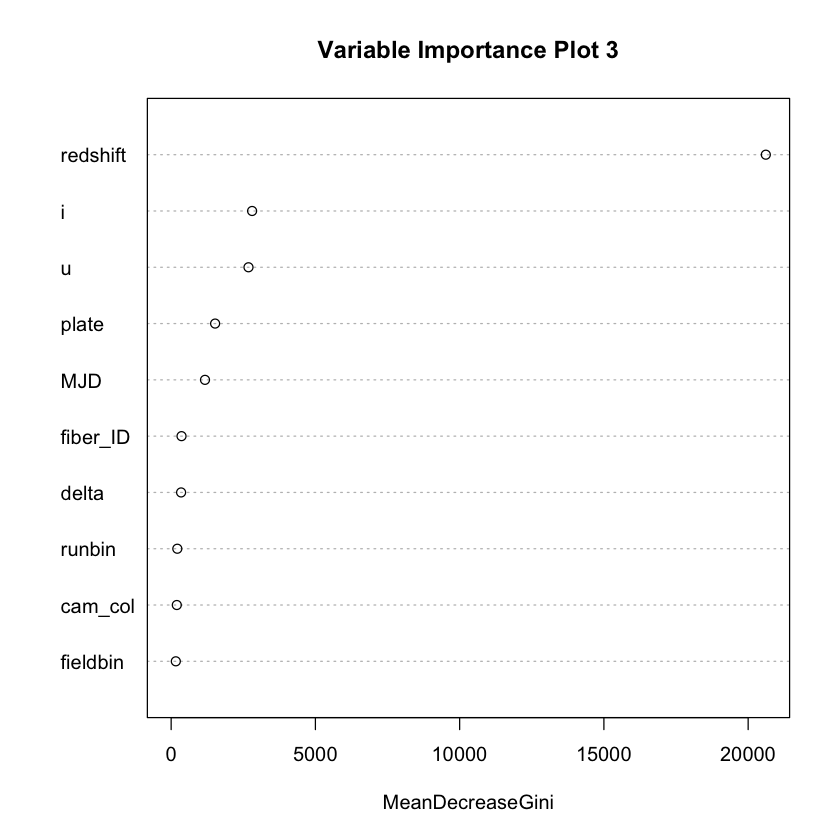

In [16]:
ntrees = 400

# cv 1
RF.1f <- randomForest(class ~ ., data = trainDat1[-1], ntree = ntrees)
print(RF.1f)
varImpPlot(RF.1f, main = "Variable Importance Plot 1")
predRF.1f <- predict(RF.1f, newdata = testDat1[-1],type = "prob")
head(predRF.1f)

# cv 2
RF.2f <- randomForest(class ~ ., data = trainDat2[-1], ntree = ntrees)
print(RF.2f)
varImpPlot(RF.2f, main = "Variable Importance Plot 2")
predRF.2f <- predict(RF.2f, newdata = testDat2[-1], type = "prob")

# cv 3
RF.3f <- randomForest(class ~ ., data = trainDat3[-1], ntree = ntrees)
print(RF.3f)
varImpPlot(RF.3f, main = "Variable Importance Plot 3")
predRF.3f <- predict(RF.3f, newdata = testDat3[-1], type = "prob")

In [18]:
predintRF.1f=CategoryPredInterval(predRF.1f,labels=c("GALAXY","QSO", "STAR"))
cat("50% Prediction Interval Table for FOLD 1")
print(table(testDat1$class,predintRF.1f$pred50))
cat("80% Prediction Interval Table for FOLD 1")
print(table(testDat1$class,predintRF.1f$pred80))

50% Prediction Interval Table for FOLD 1        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  15611         3          2   210         2    98          2
  QSO       394         3          0  4647         4     0          0
  STAR        3         0          0     0         0  5688          0
80% Prediction Interval Table for FOLD 1        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  15041       538         37    72       140    37         63
  QSO       220       177          0  4330       321     0          0
  STAR        0         0          3     0         0  5611         77


In [19]:
predintRF.2f=CategoryPredInterval(predRF.2f,labels=c("GALAXY","QSO", "STAR"))
cat("50% Prediction Interval Table for FOLD 2")
print(table(testDat2$class,predintRF.2f$pred50))
cat("80% Prediction Interval Table for FOLD 2")
print(table(testDat2$class,predintRF.2f$pred80))

50% Prediction Interval Table for FOLD 2        
         GALAXY GALAXYQSO   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  15506         3   187         3    85          1
  QSO       439         1  4646         1     3          0
  STAR        6         0     0         0  5785          0
80% Prediction Interval Table for FOLD 2        
         GALAXY GALAXYQSO GALAXYQSOSTAR GALAXYSTAR   QSO QSOGALAXY  STAR
  GALAXY  14951       509             1         48    52       138    25
  QSO       244       196             0          0  4323       324     2
  STAR        1         0             0          5     0         0  5694
        
         STARGALAXY
  GALAXY         61
  QSO             1
  STAR           91


In [20]:
predintRF.3f=CategoryPredInterval(predRF.3f,labels=c("GALAXY","QSO", "STAR"))
cat("50% Prediction Interval Table for FOLD 3")
print(table(testDat3$class,predintRF.3f$pred50))
cat("80% Prediction Interval Table for FOLD 3")
print(table(testDat3$class,predintRF.3f$pred80))

50% Prediction Interval Table for FOLD 3        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  15611         2          2   177         1    94          0
  QSO       419         2          0  4676         1     0          0
  STAR        8         0          0     0         0  5672          1
80% Prediction Interval Table for FOLD 3        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  15088       495         32    59       119    35         59
  QSO       219       201          1  4362       315     0          0
  STAR        0         0          8     0         0  5595         78


In [22]:
# cv1
cat("RF Cross Validation Misclassification rate - 50%")
misRF.1f50 <- categMisclassRates(as.matrix(table(testDat1$class,predintRF.1f$pred50)))

cat("RF Cross Validation Misclassification rate - 50% ")
misRF.1f80 <- categMisclassRates(as.matrix(table(testDat1$class,predintRF.1f$pred80)))

RF Cross Validation Misclassification rate - 50%Misclassification rate for  GALAXY :  0.019 
Misclassification rate for  QSO :  0.078 
Misclassification rate for  STAR :  0.001 
Avg Misclassification rate:  0.033 
RF Cross Validation Misclassification rate - 50% Misclassification rate for  GALAXY :  0.007 
Misclassification rate for  QSO :  0.044 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.017 


In [23]:
# cv2
cat("RF Cross Validation Misclassification rate - 50%")
misRF.2f50 <- categMisclassRates(as.matrix(table(testDat2$class,predintRF.2f$pred50)))
cat("RF Cross Validation Misclassification rate - 80%")
misRF.2f80 <- categMisclassRates(as.matrix(table(testDat2$class,predintRF.2f$pred80)))

RF Cross Validation Misclassification rate - 50%Misclassification rate for  GALAXY :  0.017 
Misclassification rate for  QSO :  0.087 
Misclassification rate for  STAR :  0.001 
Avg Misclassification rate:  0.035 
RF Cross Validation Misclassification rate - 80%Misclassification rate for  GALAXY :  0.005 
Misclassification rate for  QSO :  0.049 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.018 


In [24]:
# cv3
cat("RF Cross Validation Misclassification rate - 50%")
misRF.3f50 <- categMisclassRates(as.matrix(table(testDat3$class,predintRF.3f$pred50)))
cat("RF Cross Validation Misclassification rate - 80%")
misRF.3f80 <- categMisclassRates(as.matrix(table(testDat3$class,predintRF.3f$pred80)))

RF Cross Validation Misclassification rate - 50%Misclassification rate for  GALAXY :  0.017 
Misclassification rate for  QSO :  0.082 
Misclassification rate for  STAR :  0.001 
Avg Misclassification rate:  0.034 
RF Cross Validation Misclassification rate - 80%Misclassification rate for  GALAXY :  0.006 
Misclassification rate for  QSO :  0.043 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.016 


In [25]:
# computer avg misclass rate -- cv
misrf_50<-c(round(mean(misRF.1f50[1], misRF.2f50[1], misRF.3f50[1]), 3), 
round(mean(misRF.1f50[2], misRF.2f50[2], misRF.3f50[2]), 3), 
round(mean(misRF.1f50[3], misRF.2f50[3], misRF.3f50[3]), 3))

misrf_80<-c(round(mean(misRF.1f80[1], misRF.2f80[1], misRF.3f80[1]), 3), 
round(mean(misRF.1f80[2], misRF.2f80[2], misRF.3f80[2]), 3), 
round(mean(misRF.1f80[3], misRF.2f80[3], misRF.3f80[3]), 3))

In [26]:
cat("RF CV Prediction Interval Table")
mis_rf_result <- rbind(misrf_50, misrf_80)
colnames(mis_rf_result) <- c("GALAXY","QSO","STAR")
rownames(mis_rf_result) <- c("50% PI",  "80% PI")
mis_rf_result

RF CV Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.019,0.078,0.001
80% PI,0.007,0.044,0.000


#### 3.1.2 fit the model in holdo - RF

In [27]:
rf_pred_class_prob_holdo <- predict(RF.2f, newdata = holdo, type = "prob")
rf_predict_pi_holdo<-CategoryPredInterval(rf_pred_class_prob_holdo, c("GALAXY","QSO","STAR"))

In [28]:
rf_pi_50_holdo<-table(holdo$class,rf_predict_pi_holdo$pred50);rf_pi_50_holdo

        
         GALAXY GALAXYQSO   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  11650         3   121         0    71          0
  QSO       295         2  3427         1     0          0
  STAR        1         0     0         0  4428          1

In [29]:
rf_pi_80_holdo<-table(holdo$class,rf_predict_pi_holdo$pred80);rf_pi_80_holdo

        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY  STAR STARGALAXY
  GALAXY  11214       410         29    42        79    16         55
  QSO       151       146          0  3194       234     0          0
  STAR        0         0          1     0         0  4357         72

In [30]:
# 50% misclass
misrf_holdo50<-categMisclassRates(rf_pi_50_holdo, iprint=TRUE)

Number of misclassifications for  GALAXY : 192 
Misclassification rate for  GALAXY :  0.016 
Number of misclassifications for  QSO : 295 
Misclassification rate for  QSO :  0.079 
Number of misclassifications for  STAR : 1 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.032 


In [31]:
# 80% misclass
misrf_holdo80<-categMisclassRates(rf_pi_80_holdo, iprint=TRUE)

Number of misclassifications for  GALAXY : 58 
Misclassification rate for  GALAXY :  0.005 
Number of misclassifications for  QSO : 151 
Misclassification rate for  QSO :  0.041 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.015 


In [144]:
cat("RF Holdout Prediction Interval Table")
mis_rf_result_holdo <- round(rbind(misrf_holdo50, misrf_holdo80), 3)
colnames(mis_rf_result_holdo) <- c("GALAXY","QSO","STAR")
rownames(mis_rf_result_holdo) <- c("50% PI",  "80% PI")
mis_rf_result_holdo

RF Holdout Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.016,0.079,0
80% PI,0.005,0.041,0


### 3.2 Method 2 - Multinomial

#### 3.2.1 Multinomial CV

In [33]:
options(warn = -1)
#Build 3 different models, based on which fold, fold1 uses the first section of the data as the "test" set SUBSETTED VARIABLES
multi_1f <- vglm(class~., multinomial(), data = trainDat1[-1])
multi_2f <- vglm(class~., multinomial(), data = trainDat2[-1])
multi_3f <- vglm(class~., multinomial(), data = trainDat3[-1])

In [34]:
#Predictions for each fold
pred_multi_1f <- predict(multi_1f , newdata = testDat1[-1], type = "response") #fold1
pred_multi_2f<- predict(multi_2f , newdata = testDat2[-1], type = "response") #fold2
pred_multi_3f <- predict(multi_3f , newdata = testDat3[-1], type = "response") #fold3


In [35]:
multi_predict_pi_1<-CategoryPredInterval(pred_multi_1f, c("GALAXY","QSO","STAR"))
multi_predict_pi_2<-CategoryPredInterval(pred_multi_2f, c("GALAXY","QSO","STAR"))
multi_predict_pi_3<-CategoryPredInterval(pred_multi_3f, c("GALAXY","QSO","STAR"))

In [36]:
# cv1
cat("Multinomial Cross Validation Misclassification rate - 50%")
mismulti_1f50 <- categMisclassRates(as.matrix(table(testDat1$class, multi_predict_pi_1$pred50)))

cat("Multinomial Cross Validation Misclassification rate - 50% ")
mismulti_1f80 <- categMisclassRates(as.matrix(table(testDat1$class, multi_predict_pi_1$pred80)))

Multinomial Cross Validation Misclassification rate - 50%Misclassification rate for  GALAXY :  0.033 
Misclassification rate for  QSO :  0.128 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.054 
Multinomial Cross Validation Misclassification rate - 50% Misclassification rate for  GALAXY :  0.017 
Misclassification rate for  QSO :  0.072 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.03 


In [37]:
# cv2
cat("Multinomial Cross Validation Misclassification rate - 50%")
mismulti_2f50 <- categMisclassRates(as.matrix(table(testDat2$class, multi_predict_pi_2$pred50)))

cat("Multinomial Cross Validation Misclassification rate - 50% ")
mismulti_2f80 <- categMisclassRates(as.matrix(table(testDat2$class, multi_predict_pi_2$pred80)))

Multinomial Cross Validation Misclassification rate - 50%Misclassification rate for  GALAXY :  0.033 
Misclassification rate for  QSO :  0.133 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.055 
Multinomial Cross Validation Misclassification rate - 50% Misclassification rate for  GALAXY :  0.015 
Misclassification rate for  QSO :  0.078 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.031 


In [38]:
# cv3
cat("Multinomial Cross Validation Misclassification rate - 50%")
mismulti_3f50 <- categMisclassRates(as.matrix(table(testDat3$class, multi_predict_pi_3$pred50)))

cat("Multinomial Cross Validation Misclassification rate - 50% ")
mismulti_3f80 <- categMisclassRates(as.matrix(table(testDat3$class, multi_predict_pi_3$pred80)))

Multinomial Cross Validation Misclassification rate - 50%Misclassification rate for  GALAXY :  0.03 
Misclassification rate for  QSO :  0.127 
Misclassification rate for  STAR :  0.001 
Avg Misclassification rate:  0.052 
Multinomial Cross Validation Misclassification rate - 50% Misclassification rate for  GALAXY :  0.014 
Misclassification rate for  QSO :  0.071 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.028 


In [84]:
# computer avg misclass rate -- cv
mismulti_50<-c(round(mean(mismulti_1f50[1], mismulti_2f50[1], mismulti_3f50[1]), 3), 
round(mean(mismulti_1f50[2], mismulti_2f50[2], mismulti_3f50[2]), 3), 
round(mean(mismulti_1f50[3], mismulti_2f50[3], mismulti_3f50[3]), 3))

mismulti_80<-c(round(mean(mismulti_1f80[1], mismulti_2f80[1], mismulti_3f80[1]), 3), 
round(mean(mismulti_1f80[2], mismulti_2f80[2], mismulti_3f80[2]), 3), 
round(mean(mismulti_1f80[3], mismulti_2f80[3], mismulti_3f80[3]), 3))

In [85]:
cat("Multinomial CV Prediction Interval Table")
mis_multi_result_cv <- rbind(mismulti_50, mismulti_80)
colnames(mis_multi_result_cv) <- c("GALAXY","QSO","STAR")
rownames(mis_multi_result_cv) <- c("50% PI",  "80% PI")
mis_multi_result_cv

Multinomial CV Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.033,0.128,0
80% PI,0.017,0.072,0


#### 3.2.2 fit the model in holdo - Multi

In [41]:
multi_pred_class_prob_holdo <- predict(multi_3f , newdata = holdo, type = "response")
multi_predict_pi_holdo<-CategoryPredInterval(multi_pred_class_prob_holdo, c("GALAXY","QSO","STAR"))

In [42]:
multi_pi_50_holdo<-table(holdo$class,multi_predict_pi_holdo$pred50);multi_pi_50_holdo

        
         GALAXY GALAXYSTAR   QSO  STAR STARGALAXY
  GALAXY  11460         12   184   180          9
  QSO       452          0  3272     1          0
  STAR        0          0     0  4430          0

In [43]:
multi_pi_80_holdo<-table(holdo$class,multi_predict_pi_holdo$pred80);multi_pi_80_holdo

        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY  STAR STARGALAXY STARQSO
  GALAXY  10775       480        217    60       124   115         73       1
  QSO       265       186          1  2957       315     1          0       0
  STAR        0         0          0     0         0  4385         38       7

In [44]:
# 50% misclass
mismulti_holdo50<-categMisclassRates(multi_pi_50_holdo, iprint=TRUE)

Number of misclassifications for  GALAXY : 364 
Misclassification rate for  GALAXY :  0.031 
Number of misclassifications for  QSO : 453 
Misclassification rate for  QSO :  0.122 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.051 


In [45]:
# 80% misclass
mismulti_holdo80<-categMisclassRates(multi_pi_80_holdo, iprint=TRUE)

Number of misclassifications for  GALAXY : 176 
Misclassification rate for  GALAXY :  0.015 
Number of misclassifications for  QSO : 267 
Misclassification rate for  QSO :  0.072 
Number of misclassifications for  STAR : 0 
Misclassification rate for  STAR :  0 
Avg Misclassification rate:  0.029 


In [46]:
cat("Multinomial Holdout Prediction Interval Table")
mis_multi_result_holdo <- round(rbind(mismulti_holdo50, mismulti_holdo80), 3)
colnames(mis_multi_result_holdo) <- c("GALAXY","QSO","STAR")
rownames(mis_multi_result_holdo) <- c("50% PI",  "80% PI")
mis_multi_result_holdo

Multinomial Holdout Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.031,0.122,0
80% PI,0.015,0.072,0


## 3.3 Method 3 -- Caret kNN-rf

#### 3.3.1 kNN CV Implementation

In [48]:
# reload data which is specifically pruned for kNN
kNN_star <- read.csv("./kNN_data/kNN_PhaseA_star_rf.csv")

In [52]:
# transfer variable types for alogrithms 
kNN_star <- kNN_star %>% mutate(
  class = factor(class))

In [54]:
# train holdo split
set.seed(447)
kNN_train<- sample_n(kNN_star, size = nrow(kNN_star) * 0.80,
  replace = FALSE
)

kNN_holdo <- anti_join(kNN_star,
  kNN_train,
  by = "X"
)

In [55]:
# drop X(id) col in holdo
kNN_holdo <- kNN_holdo[-1]

In [57]:
# transfer class levels for package to work
kNN_train <- kNN_train %>% mutate(class =
                     case_when(class == "GALAXY" ~ "X1",
                               class == "QSO" ~ "X2",
                               class == "STAR" ~ "X3"))

kNN_train$class <- factor(kNN_train$class) 

In [58]:
set.seed(447)

# 3-fold, preparation for cross-validated performance
n = nrow(kNN_train)
iperm=sample(n)
nFold <- round(n/3) 
ifold1=iperm[1:nFold]
ifold2=iperm[(nFold+1):(2*nFold)]
ifold3=iperm[(2*nFold+1):(n)]

#cv1: ifold1&2 
trainDat1<-kNN_train[-ifold3,-which(colnames(kNN_train) == "X")]
testDat1<-kNN_train[ifold3, -which(colnames(kNN_train) == "X")]

#fold2: ifold2&3
trainDat2<-kNN_train[-ifold1,-which(colnames(kNN_train) == "X")]
testDat2<-kNN_train[ifold1,-which(colnames(kNN_train) == "X")]

#fold3: ifold1&3 
trainDat3<-kNN_train[-ifold2,-which(colnames(kNN_train) == "X")]
testDat3<-kNN_train[ifold2,-which(colnames(kNN_train) == "X")]

In [59]:
# convert colnames of prediction and holdo result back to original names 
testDat1<-testDat1 %>% mutate(class =
                     case_when(class == "X1" ~ "GALAXY",
                               class == "X2" ~ "QSO",
                               class == "X3" ~ "STAR"))
# convert colnames of prediction and holdo result back to original names 
testDat2<-testDat2 %>% mutate(class =
                     case_when(class == "X1" ~ "GALAXY",
                               class == "X2" ~ "QSO",
                               class == "X3" ~ "STAR"))
# convert colnames of prediction and holdo result back to original names 
testDat3<-testDat3 %>% mutate(class =
                     case_when(class == "X1" ~ "GALAXY",
                               class == "X2" ~ "QSO",
                               class == "X3" ~ "STAR"))

In [60]:
# k is usually set as the square root of number of observations
kk <-round(sqrt(0.33*kNN_train%>%nrow()),);kk

[1] 162

In [63]:
# make a grid of values to test in cross-validation,
# k usually set as sqrt of observations, 162 in our case. 
# So a range of k are tested, from 140 to 180
set.seed(447)
 knnGrid <-  expand.grid(k =seq(140,180,2))


**For Prof and TA,<br/>Cell below has 5+ hrs (over night) Run Time**

In [64]:
# model training fold1
set.seed(447)
knnFit_1 <- train(class ~ ., # formula
                 data = trainDat1, # train data 
                 method = "knn",
                 tuneGrid = knnGrid)

# model training fold2
knnFit_2 <- train(class ~ ., # formula
                 data = trainDat2, # train data 
                method = "knn",
                 tuneGrid = knnGrid)

# model training fold3
knnFit_3 <- train(class ~ ., # formula
                 data = trainDat3, # train data 
                 method = "knn",
                 tuneGrid = knnGrid)

k-Nearest Neighbors 

53332 samples
    9 predictor
    3 classes: 'X1', 'X2', 'X3' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 53332, 53332, 53332, 53332, 53332, 53332, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
  140  0.9181986  0.8524433
  142  0.9178805  0.8518428
  144  0.9175500  0.8512102
  146  0.9172992  0.8507289
  148  0.9169953  0.8501518
  150  0.9166832  0.8495608
  152  0.9163549  0.8489362
  154  0.9161161  0.8484750
  156  0.9158309  0.8479395
  158  0.9155046  0.8473168
  160  0.9152801  0.8468797
  162  0.9149638  0.8462802
  164  0.9146604  0.8457006
  166  0.9143648  0.8451441
  168  0.9140320  0.8445109
  170  0.9137955  0.8440492
  172  0.9135712  0.8436235
  174  0.9132915  0.8430854
  176  0.9129346  0.8424053
  178  0.9126938  0.8419411
  180  0.9123575  0.8412948

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 140.

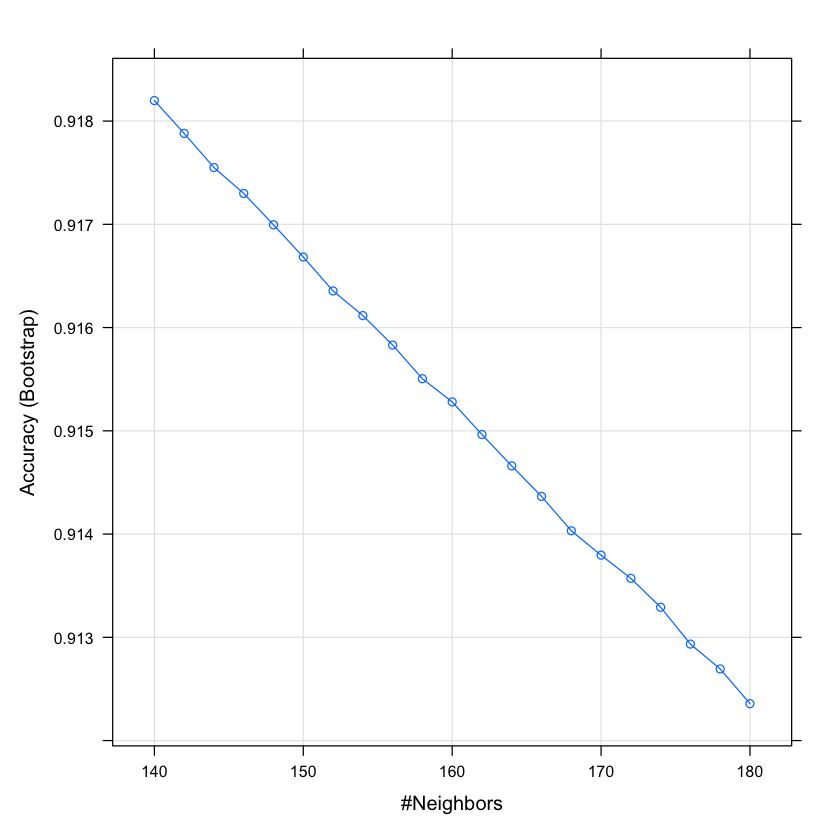

In [65]:
# plot to see the best k 
knnFit_1
plot(knnFit_1)

k-Nearest Neighbors 

53333 samples
    9 predictor
    3 classes: 'X1', 'X2', 'X3' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 53333, 53333, 53333, 53333, 53333, 53333, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
  140  0.9152855  0.8463107
  142  0.9149103  0.8455941
  144  0.9146902  0.8451673
  146  0.9144821  0.8447650
  148  0.9142191  0.8442483
  150  0.9138684  0.8435817
  152  0.9135178  0.8429216
  154  0.9133467  0.8425923
  156  0.9130385  0.8419987
  158  0.9128406  0.8416116
  160  0.9126141  0.8411823
  162  0.9123530  0.8406768
  164  0.9120023  0.8400003
  166  0.9117921  0.8395990
  168  0.9116046  0.8392323
  170  0.9113313  0.8387017
  172  0.9110909  0.8382367
  174  0.9108175  0.8376987
  176  0.9105744  0.8372216
  178  0.9102301  0.8365555
  180  0.9099874  0.8360880

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 140.

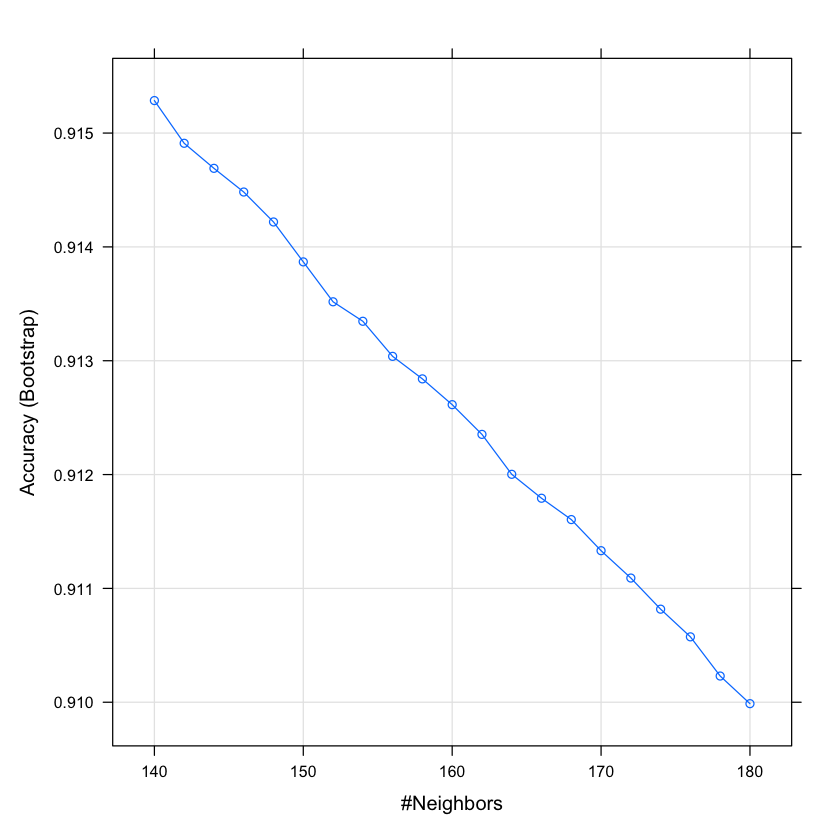

In [66]:
# plot to see the best k 
knnFit_2
plot(knnFit_2)

k-Nearest Neighbors 

53333 samples
    9 predictor
    3 classes: 'X1', 'X2', 'X3' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 53333, 53333, 53333, 53333, 53333, 53333, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
  140  0.9138230  0.8439643
  142  0.9136433  0.8436214
  144  0.9133742  0.8431097
  146  0.9131133  0.8426119
  148  0.9127709  0.8419638
  150  0.9125241  0.8414885
  152  0.9122447  0.8409492
  154  0.9119674  0.8404199
  156  0.9117391  0.8399784
  158  0.9114517  0.8394191
  160  0.9112147  0.8389698
  162  0.9109943  0.8385377
  164  0.9108271  0.8382136
  166  0.9105399  0.8376693
  168  0.9102829  0.8371734
  170  0.9101298  0.8368679
  172  0.9098688  0.8363735
  174  0.9096279  0.8359148
  176  0.9095035  0.8356589
  178  0.9091976  0.8350795
  180  0.9089653  0.8346322

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 140.

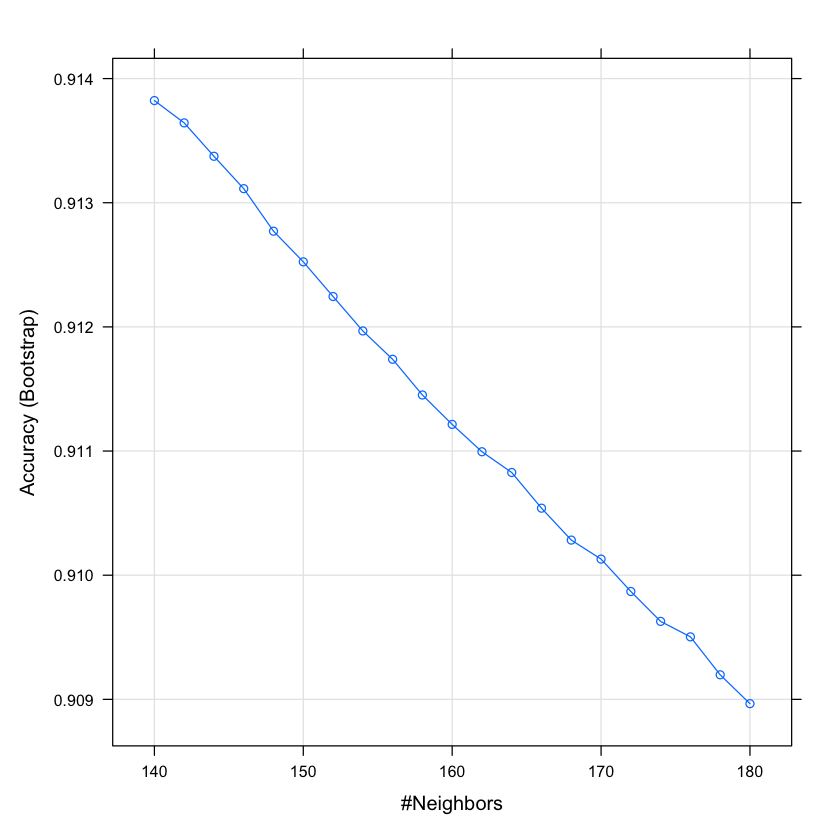

In [67]:
# plot to see the best k 
knnFit_3
plot(knnFit_3)

In [68]:
# get prediction result by using the pretrained model and best performed k
knn_pred_class_prob_1 <- predict(knnFit_1, newdata = testDat1, 'prob')

knn_pred_class_prob_2 <- predict(knnFit_2, newdata = testDat2, 'prob')

knn_pred_class_prob_3 <- predict(knnFit_3, newdata = testDat3, 'prob')

In [69]:
# transfer result to matrix form
knn_pred_class_prob_1 <- data.matrix(knn_pred_class_prob_1,rownames.force = T)
knn_pred_class_prob_2 <- data.matrix(knn_pred_class_prob_2,rownames.force = T)
knn_pred_class_prob_3 <- data.matrix(knn_pred_class_prob_3,rownames.force = T)

In [70]:
# get quantile
maxprob_1=apply(knn_pred_class_prob_1,1,max)
print(summary(maxprob_1))
maxprob_2=apply(knn_pred_class_prob_2,1,max)
print(summary(maxprob_2))
maxprob_3=apply(knn_pred_class_prob_3,1,max)
print(summary(maxprob_3))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3429  0.8857  0.9786  0.9113  1.0000  1.0000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3571  0.8857  0.9786  0.9102  1.0000  1.0000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3571  0.8857  0.9786  0.9105  1.0000  1.0000 


In [71]:
# PI compute
knn_predict_pi_1<-CategoryPredInterval(knn_pred_class_prob_1, c("GALAXY","QSO","STAR"))
knn_predict_pi_2<-CategoryPredInterval(knn_pred_class_prob_2, c("GALAXY","QSO","STAR"))
knn_predict_pi_3<-CategoryPredInterval(knn_pred_class_prob_3, c("GALAXY","QSO","STAR"))

In [73]:
# Print reult of PI 
knn_pi_50_1<-table(testDat1$class,knn_predict_pi_1$pred50);knn_pi_50_1
knn_pi_50_2<-table(testDat2$class,knn_predict_pi_2$pred50);knn_pi_50_2
knn_pi_50_3<-table(testDat3$class,knn_predict_pi_3$pred50);knn_pi_50_3

        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY QSOSTAR  STAR STARGALAXY
  GALAXY  15140         5         49   158         3       3   533         32
  QSO       422         9          8  4511         4       3    79          7
  STAR      985         0         11     0         0       0  4683          9
        
         STARQSO
  GALAXY       5
  QSO          5
  STAR         3

        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY QSOSTAR  STAR STARGALAXY
  GALAXY  15060         6         37   141         4       3   500         31
  QSO       469         7          6  4519        13       7    55          9
  STAR      991         0         18     1         0       0  4761         18
        
         STARQSO
  GALAXY       3
  QSO          5
  STAR         2

        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY QSOSTAR  STAR STARGALAXY
  GALAXY  15189         8         39   127         5       2   491         22
  QSO       437        12          5  4543         8       7    71         10
  STAR      985         0         31     0         0       2  4649         14
        
         STARQSO
  GALAXY       4
  QSO          5
  STAR         0

In [74]:
# Misclassfification Rate compute
misknn_1f50<-categMisclassRates(knn_pi_50_1, iprint=TRUE)

Number of misclassifications for  GALAXY : 699 
Misclassification rate for  GALAXY :  0.044 
Number of misclassifications for  QSO : 516 
Misclassification rate for  QSO :  0.102 
Number of misclassifications for  STAR : 985 
Misclassification rate for  STAR :  0.173 
Avg Misclassification rate:  0.106 


In [75]:
# Misclassfification Rate compute
misknn_2f50<-categMisclassRates(knn_pi_50_2, iprint=TRUE)

Number of misclassifications for  GALAXY : 647 
Misclassification rate for  GALAXY :  0.041 
Number of misclassifications for  QSO : 539 
Misclassification rate for  QSO :  0.106 
Number of misclassifications for  STAR : 992 
Misclassification rate for  STAR :  0.171 
Avg Misclassification rate:  0.106 


In [76]:
# Misclassfification Rate compute
misknn_3f50<-categMisclassRates(knn_pi_50_3, iprint=TRUE)

Number of misclassifications for  GALAXY : 624 
Misclassification rate for  GALAXY :  0.039 
Number of misclassifications for  QSO : 523 
Misclassification rate for  QSO :  0.103 
Number of misclassifications for  STAR : 985 
Misclassification rate for  STAR :  0.173 
Avg Misclassification rate:  0.105 


In [77]:
# 80% PI
knn_pi_80_1<-table(testDat1$class,knn_predict_pi_1$pred80);knn_pi_80_1
knn_pi_80_2<-table(testDat2$class,knn_predict_pi_2$pred80);knn_pi_80_2
knn_pi_80_3<-table(testDat3$class,knn_predict_pi_3$pred80);knn_pi_80_3

        
         GALAXY GALAXYQSO GALAXYQSOSTAR GALAXYSTAR GALAXYSTARQSO   QSO
  GALAXY  13831       170             4       1182             7    66
  QSO       266       123             7         37             6  4221
  STAR      216         0             0        780             0     0
        
         QSOGALAXY QSOGALAXYSTAR QSOSTAR QSOSTARGALAXY  STAR STARGALAXY
  GALAXY        91             3       2             2   138        409
  QSO          249             2      44             2    31         34
  STAR           0             0       0             0  3228       1454
        
         STARGALAXYQSO STARQSO STARQSOGALAXY
  GALAXY            13       6             4
  QSO                5      18             3
  STAR               1      10             2

        
         GALAXY GALAXYQSO GALAXYQSOSTAR GALAXYSTAR GALAXYSTARQSO   QSO
  GALAXY  13826       170             5       1095             7    50
  QSO       267       159             2         49             5  4223
  STAR      191         0             0        818             0     0
        
         QSOGALAXY QSOGALAXYSTAR QSOSTAR QSOSTARGALAXY  STAR STARGALAXY
  GALAXY        90             3       1             4   125        383
  QSO          277             3      31             5    23         25
  STAR           0             0       1             0  3228       1533
        
         STARGALAXYQSO STARQSO STARQSOGALAXY
  GALAXY            13       6             7
  QSO                4      14             3
  STAR               3      13             4

        
         GALAXY GALAXYQSO GALAXYQSOSTAR GALAXYSTAR GALAXYSTARQSO   QSO
  GALAXY  13887       189             7       1149             4    51
  QSO       260       145             4         42             3  4252
  STAR      197         0             0        819             0     0
        
         QSOGALAXY QSOGALAXYSTAR QSOSTAR QSOSTARGALAXY  STAR STARGALAXY
  GALAXY        77             4       0             2   126        371
  QSO          267             5      28             6    21         40
  STAR           0             0       2             0  3178       1475
        
         STARGALAXYQSO STARQSO STARQSOGALAXY
  GALAXY             6      11             3
  QSO                5      16             4
  STAR               0       9             1

In [78]:
# 80% misclassification
misknn_1f80<-categMisclassRates(knn_pi_80_1, iprint=TRUE)
misknn_2f80<-categMisclassRates(knn_pi_80_2, iprint=TRUE)
misknn_3f80<-categMisclassRates(knn_pi_80_3, iprint=TRUE)

Number of misclassifications for  GALAXY : 212 
Misclassification rate for  GALAXY :  0.013 
Number of misclassifications for  QSO : 368 
Misclassification rate for  QSO :  0.073 
Number of misclassifications for  STAR : 216 
Misclassification rate for  STAR :  0.038 
Avg Misclassification rate:  0.041 
Number of misclassifications for  GALAXY : 182 
Misclassification rate for  GALAXY :  0.012 
Number of misclassifications for  QSO : 364 
Misclassification rate for  QSO :  0.072 
Number of misclassifications for  STAR : 191 
Misclassification rate for  STAR :  0.033 
Avg Misclassification rate:  0.039 
Number of misclassifications for  GALAXY : 188 
Misclassification rate for  GALAXY :  0.012 
Number of misclassifications for  QSO : 363 
Misclassification rate for  QSO :  0.071 
Number of misclassifications for  STAR : 197 
Misclassification rate for  STAR :  0.035 
Avg Misclassification rate:  0.039 


In [ ]:
# average misclassification rate on each fold
misknn_50pi <- round(rbind(misknn_1f50, misknn_2f50, misknn_3f50),3)
misknn_50pi <- round(cbind(misknn_50pi, rowMeans(misknn_50pi)),3)
colnames(misknn_50pi) <- c("GALAXY","QSO","STAR", "average")
misknn_50pi <- round(rbind(misknn_50pi, colMeans(misknn_50pi)),3)
rownames(misknn_50pi) <- c("1-fold",  "2-fold", "3-fold",  "average")

In [80]:
misknn_50pi

,GALAXY,QSO,STAR,average
1-fold,0.044,0.102,0.173,0.106
2-fold,0.041,0.106,0.171,0.106
3-fold,0.039,0.103,0.173,0.105
average,0.041,0.104,0.172,0.106


In [81]:
# average misclassification rate on each fold
misknn_80pi <- round(rbind(misknn_1f80, misknn_2f80, misknn_3f80),3)
misknn_80pi <- round(cbind(misknn_80pi, rowMeans(misknn_80pi)),3)
colnames(misknn_80pi) <- c("GALAXY","QSO","STAR", "average")
misknn_80pi <- round(rbind(misknn_80pi, colMeans(misknn_80pi)),3)
rownames(misknn_80pi) <- c("1-fold",  "2-fold", "3-fold",  "average")

In [82]:
misknn_80pi

,GALAXY,QSO,STAR,average
1-fold,0.013,0.073,0.038,0.041
2-fold,0.012,0.072,0.033,0.039
3-fold,0.012,0.071,0.035,0.039
average,0.012,0.072,0.035,0.040


In [83]:
# computer avg misclass rate -- cv
misknn_50<-c(round(mean(misknn_1f50[1], misknn_1f50[1], misknn_1f50[1]), 3), 
round(mean(misknn_2f50[2], misknn_2f50[2], misknn_2f50[2]), 3), 
round(mean(misknn_3f50[3], misknn_3f50[3], misknn_3f50[3]), 3))

misknn_80<-c(round(mean(misknn_1f80[1], misknn_1f80[1], misknn_1f80[1]), 3), 
round(mean(misknn_1f80[2], misknn_2f80[2], misknn_3f80[2]), 3), 
round(mean(misknn_3f80[3], misknn_3f80[3], misknn_3f80[3]), 3))

In [86]:
cat("kNN CV Prediction Interval Table")
mis_multi_result_cv <- rbind(misknn_50, misknn_80)
colnames(mis_multi_result_cv) <- c("GALAXY","QSO","STAR")
rownames(mis_multi_result_cv) <- c("50% PI",  "80% PI")
mis_multi_result_cv

kNN CV Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.044,0.106,0.173
80% PI,0.013,0.073,0.035


#### 3.3.2 kNN--Fit Model on Holdout Set

In [88]:
# since all three models have same k, randomly choose fit3
knn_pred_class_prob_holdo <- predict(knnFit_3, newdata = kNN_holdo, 'prob')
knn_pred_class_prob_holdo <- data.matrix(knn_pred_class_prob_holdo,rownames.force = T)

In [89]:
knn_predict_pi_holdo<-CategoryPredInterval(knn_pred_class_prob_holdo, c("GALAXY","QSO","STAR"))

In [91]:
knn_pi_50_holdo<-table(kNN_holdo$class,knn_predict_pi_holdo$pred50);knn_pi_50_holdo

        
         GALAXY GALAXYQSO GALAXYSTAR   QSO QSOGALAXY QSOSTAR  STAR STARGALAXY
  GALAXY  11320         7         26    90         2       1   381         12
  QSO       310         7          2  3331         6       8    50          7
  STAR      784         0         14     0         0       1  3622          5
        
         STARQSO
  GALAXY       6
  QSO          4
  STAR         4

In [92]:
misknn_holdo50<-categMisclassRates(knn_pi_50_holdo, iprint=TRUE)

Number of misclassifications for  GALAXY : 478 
Misclassification rate for  GALAXY :  0.04 
Number of misclassifications for  QSO : 369 
Misclassification rate for  QSO :  0.099 
Number of misclassifications for  STAR : 784 
Misclassification rate for  STAR :  0.177 
Avg Misclassification rate:  0.105 


In [93]:
knn_pi_80_holdo<-table(kNN_holdo$class,knn_predict_pi_holdo$pred80);knn_pi_80_holdo

        
         GALAXY GALAXYQSO GALAXYQSOSTAR GALAXYSTAR GALAXYSTARQSO   QSO
  GALAXY  10345       140             5        859             4    34
  QSO       188       104             2         22             3  3139
  STAR      156         0             0        642             0     0
        
         QSOGALAXY QSOGALAXYSTAR QSOSTAR QSOSTARGALAXY  STAR STARGALAXY
  GALAXY        55             1       2             1    95        286
  QSO          183             4      15             4    12         25
  STAR           0             0       1             0  2437       1183
        
         STARGALAXYQSO STARQSO STARQSOGALAXY
  GALAXY             7       6             5
  QSO                5      15             4
  STAR               0       9             2

In [94]:
misknn_holdo80<-categMisclassRates(knn_pi_80_holdo, iprint=TRUE)

Number of misclassifications for  GALAXY : 137 
Misclassification rate for  GALAXY :  0.012 
Number of misclassifications for  QSO : 247 
Misclassification rate for  QSO :  0.066 
Number of misclassifications for  STAR : 156 
Misclassification rate for  STAR :  0.035 
Avg Misclassification rate:  0.038 


In [124]:
cat("kNN Holdout Prediction Interval Table")
mis_knn_result_holdo <- round(rbind(misknn_holdo50, misknn_holdo80), 3)
colnames(mis_knn_result_holdo) <- c("GALAXY","QSO","STAR")
rownames(mis_knn_result_holdo) <- c("50% PI",  "80% PI")
mis_knn_result_holdo

kNN Holdout Prediction Interval Table

,GALAXY,QSO,STAR
50% PI,0.040,0.099,0.177
80% PI,0.012,0.066,0.035


### 4. Model Comparison on Holdout Set

In [154]:
# calculating Avg misclassification rate for each model. 

mis_rf_result_holdo <- rbind(round(mis_rf_result_holdo[1,] %>% mean(), 3),
  round(mis_rf_result_holdo[2,] %>% mean(), 3))

mis_multi_result_holdo <- rbind(round(mis_multi_result_holdo[1,] %>% mean(), 3),
  round(mis_multi_result_holdo[2,] %>% mean(), 3))

mis_knn_result_holdo <- rbind(round(mis_knn_result_holdo[1,] %>% mean(), 3),
  round(mis_knn_result_holdo[2,] %>% mean(), 3))

holdoms <- cbind(mis_multi_result_holdo, mis_knn_result_holdo, mis_rf_result_holdo)
colnames(holdoms) <- c("Multinomial","kNN-rf", "Random Forest")
rownames(holdoms) <- c("Avg 50% PI",  "Avg 80% PI")

cat("Model Comparison Table for Holdout Set")
holdoms

Model Comparison Table for Holdout Set

,Multinomial,kNN-rf,Random Forest
Avg 50% PI,0.051,0.105,0.032
Avg 80% PI,0.029,0.038,0.015
